In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from main import load_and_prepare_sessions
from analysis.performance_funcs import add_performance_container
from processing.timepoint_analysis import aggregate_signals
from data.mouse import create_mice_dict
from analysis.response_metrics import calculate_signal_response_metrics
from scipy.stats import ttest_ind

from collections import defaultdict
import matplotlib.pyplot as plt

sessions = load_and_prepare_sessions("../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
mice_dict = create_mice_dict(sessions)

In [3]:
for mouse in mice_dict.values():
    add_performance_container(mouse)

    for session in mouse.sessions:
        session.metric_container = mouse.metric_container

In [4]:
session_metric_order = defaultdict(list)

for idx, session in enumerate(sessions):
    for metric, val in session.metric_container.data.items():
        session_metric_order[metric].append((idx, val))

metric_session_order = {}
for metric, pairs in session_metric_order.items():
    sorted_metrics = sorted(pairs, key=lambda t: t[-1])
    metric_session_order[metric] = list(zip(*sorted_metrics))[0]

  0%|          | 0/7 [00:00<?, ?it/s]

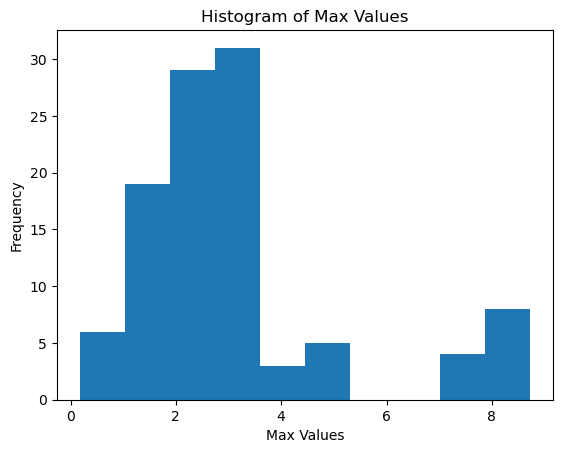

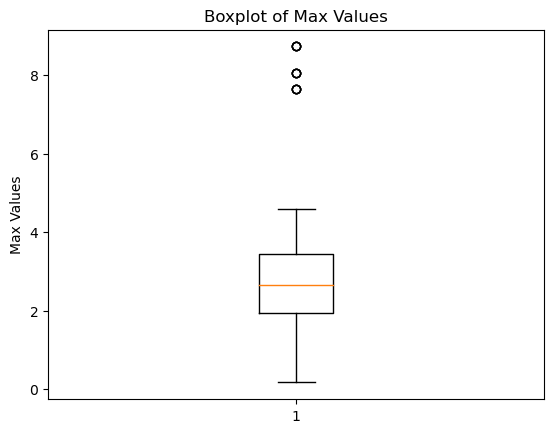

In [7]:
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import numpy as np
import numpy as np


def is_relevant_session(brain_regions, event_type, idx):
    curr_session = sessions[idx]
    return ((brain_regions[0] in curr_session.brain_regions or brain_regions[1] in curr_session.brain_regions)
            and curr_session.timepoints_container.get_data(event_type))

results = []
for metric, session_order in tqdm(metric_session_order.items()): 
    for brain_regions in [['VS_left', 'VS_right'], ['DMS_left', 'DMS_right'], ['DLS_left', 'DLS_right']]:
        for event_type in ['hit', 'mistake', 'miss', 'cor_reject', 'reward_collect']:
            ordered_filtered_sessions = [sessions[idx] for idx in session_order if 
                                         is_relevant_session(brain_regions, event_type, idx)]

            worst_sessions = ordered_filtered_sessions[:5]
            best_sessions = ordered_filtered_sessions[-5:]

            current_brain_reg = brain_regions[0].split('_')[0]
            suffix = f"{metric}_{current_brain_reg}_{event_type}"
            
            worst_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in worst_sessions)
            
            best_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in best_sessions)

            all_sessions_responses = []
            for curr_sessions in [worst_sessions, best_sessions]:            
                xs, all_ys, (start_event_idx, end_event_idx) = aggregate_signals(curr_sessions, event_type, brain_regions, 
                                                                             aggregate_by_session=False, 
                                                                             normalize_baseline=True, 
                                                                             fetch_all_signals=True)
                sessions_responses = defaultdict(list)
                for ys in all_ys:
                    curr_response_metrics = calculate_signal_response_metrics(ys, (start_event_idx, end_event_idx))
                    for response_metric, response_value in curr_response_metrics.items():
                        if np.isinf(response_value):
                            continue
                            
                        sessions_responses[response_metric].append(response_value)
                all_sessions_responses.append(sessions_responses)
                
            # Perform t-test
            for response_metric in curr_response_metrics.keys():
                all_sessions_responses[0][response_metric], all_sessions_responses[1][response_metric]
                t_statistic, p_value = ttest_ind(all_sessions_responses[0][response_metric], 
                                                 all_sessions_responses[1][response_metric], nan_policy='omit')
                result = {
                    'key': suffix + "_" + response_metric,
                    'T-Statistic': t_statistic,
                    'P-Value': p_value
                }
                if np.isnan(p_value):
                    continue
                results.append(result)

# Sort the list of dictionaries by P-Value
sorted_results = sorted(results, key=lambda x: x['P-Value'])

In [6]:
print(len(sorted_results))

525


In [72]:
import pandas as pd
# Print the sorted results
for sorted_result in sorted_results:
    print(sorted_result['key'])
    print("T-Statistic:", sorted_result['T-Statistic'])
    print("P-Value:", sorted_result['P-Value'])
    print('')

# Create a list of dictionaries from the sorted results
sorted_results_list = []
for sorted_result in sorted_results:
    sorted_results_list.append({
        'key': sorted_result['key'],
        'T-Statistic': sorted_result['T-Statistic'],
        'P-Value': sorted_result['P-Value']
    })

# Create a DataFrame from the list of dictionaries
df_sorted_results = pd.DataFrame(sorted_results_list)

# Save the DataFrame to a CSV file
df_sorted_results.to_csv('sorted_p_values.csv', index=False)



participation_VS_hit_auc
T-Statistic: -17.758382013078347
P-Value: 3.159806625223198e-51

total_hits_VS_hit_auc
T-Statistic: -12.42259433963072
P-Value: 5.125406364390917e-30

participation_VS_hit_maximal_value
T-Statistic: -12.407451283134444
P-Value: 1.0348880314814963e-29

total_hits_VS_reward_collect_auc
T-Statistic: -11.20657053052421
P-Value: 2.148295568397935e-25

participation_VS_reward_collect_auc
T-Statistic: -10.962729090329548
P-Value: 2.476850966114454e-24

participation_VS_reward_collect_maximal_value
T-Statistic: -10.766828675063595
P-Value: 1.2480962601534702e-23

total_mistakes_VS_hit_auc
T-Statistic: -9.298385996097222
P-Value: 1.5591979558476648e-18

total_mistakes_DLS_cor_reject_maximal_value
T-Statistic: 8.457886134489888
P-Value: 5.0156108737485796e-17

false_alarm_rate_DLS_cor_reject_maximal_value
T-Statistic: 8.457886134489875
P-Value: 5.0156108737490856e-17

d_prime_VS_cor_reject_maximal_value
T-Statistic: 8.458016453449638
P-Value: 5.2025574653721666e-17

part